In [158]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time
import plotly.express as px
import plotly.graph_objects as go
import random 

from ChemClean import *
from Descriptors import *

In [2]:
import rdkit.Chem as Chem
from rdkit.Chem import rdMolDescriptors 

In [132]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.utils import shuffle

import statsmodels.api as sm

## Load data from url

In [201]:
url='https://raw.githubusercontent.com/akashjn/DataScience/main/Data/BTZ_5442mols_smiles_redpot.csv'
data=pd.read_csv(url)
data=data.sample(frac=1)
data.index=range(data.shape[0])
data.head()

,SMILES,ERed
0,CCCCc1c2c(cc3nsnc13)N(CC)CN2CC,1.02
1,CCOc1c2c(cc3nsnc13)OC(C)C(CC)O2,1.64
2,CC1COc2c(c3c(c4nsnc24)C(C)CCN3C)O1,1.31
3,CCCCc1c2c(c(OC)c3nsnc13)OC(CC)CO2,1.44
4,CCCN1CC(C)Cc2cc3nsnc3cc21,1.36


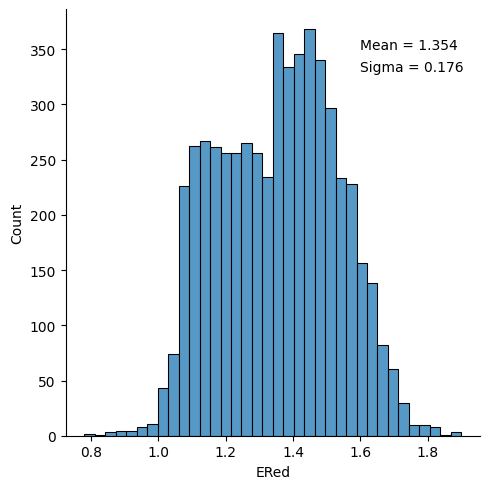

In [202]:
ax=sns.displot(data, x="ERed")
plt.text(1.6,350,'Mean = '+str(np.round(np.mean(data['ERed']),3)))
plt.text(1.6,330,'Sigma = '+str(np.round(np.std(data['ERed']),3)))
plt.show()

## Generate descriptors using Descriptors.py

In [203]:
%%time
p=desc(data['SMILES'][:5000])
df_rdkit=p.RDkit_descriptors()
print(df_rdkit.shape)
df_rdkit.head()

(5000, 208)
CPU times: user 53.4 s, sys: 0 ns, total: 53.4 s
Wall time: 53.4 s


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,4.554044,0.997514,4.554044,0.997514,0.840992,290.436,268.260,290.156518,108,0,...,0,0,0,0,0,0,0,0,0,0
1,6.041389,0.024094,6.041389,0.024094,0.864653,280.349,264.221,280.088163,102,0,...,0,0,0,0,0,0,0,0,0,0
2,6.096620,0.070627,6.096620,0.070627,0.746701,291.376,274.240,291.104148,106,0,...,0,0,0,0,0,0,0,0,0,0
3,6.088096,0.064324,6.088096,0.064324,0.844569,308.403,288.243,308.119463,114,0,...,0,0,0,0,0,0,0,0,0,0
4,4.344302,0.734347,4.344302,0.734347,0.816259,247.367,230.231,247.114319,90,0,...,0,0,0,0,0,0,0,0,0,0


## Data cleaning operations from ChemClean.py

In [204]:
p=clean(df_rdkit)

In [205]:
p.remove_nan().head()
p.remove_unique().head()
p.remove_columns_low_std(0.1).head()
df_model=p.remove_corr_features(0.7)
print(df_model.shape)
df_model.head()

Removing 0 columns with nan, if any
Before: df.shape=(5000, 208)
After: df.shape=(5000, 208) 

removing 84 columns values with a unique value
Before: df.shape=(5000, 208)
After: df.shape=(5000, 124) 

Removed 10 columns with std < 0.1 
Dropped 75 features with correlation coeff. > 0.70
(5000, 39)


,MaxEStateIndex,MinEStateIndex,MolWt,FpDensityMorgan1,BCUT2D_MWLOW,BCUT2D_LOGPLOW,BalabanJ,HallKierAlpha,PEOE_VSA10,PEOE_VSA11,...,VSA_EState2,VSA_EState8,VSA_EState9,NHOHCount,NumAliphaticHeterocycles,fr_ArN,fr_Ndealkylation1,fr_aryl_methyl,fr_bicyclic,fr_unbrch_alkane
0,4.554044,0.997514,290.436,1.150000,10.022175,-2.300516,2.188472,-1.36,11.033401,0.000000,...,4.912380,9.784488,0.000000,0,1,0,0,1,2,0
1,6.041389,0.024094,280.349,1.315789,10.111183,-2.366948,2.157760,-1.56,17.724633,17.015724,...,0.000000,6.590447,0.000000,0,1,0,0,0,2,0
2,6.096620,0.070627,291.376,1.200000,9.892883,-2.314727,2.094885,-1.56,18.227549,17.015724,...,2.258287,5.883243,2.110373,0,2,0,0,0,6,0
3,6.088096,0.064324,308.403,1.238095,10.028445,-2.288051,2.182146,-1.56,18.227549,17.015724,...,0.000000,4.845442,1.637931,0,1,0,0,1,2,0
4,4.344302,0.734347,247.367,1.352941,9.930727,-2.343149,2.099513,-1.16,11.033401,0.000000,...,2.502269,6.876281,0.000000,0,1,0,0,0,2,0


In [206]:
p=0.02
target=data['ERed'][:5000]
features=df_model.copy()
features.shape
features.head()

,MaxEStateIndex,MinEStateIndex,MolWt,FpDensityMorgan1,BCUT2D_MWLOW,BCUT2D_LOGPLOW,BalabanJ,HallKierAlpha,PEOE_VSA10,PEOE_VSA11,...,VSA_EState2,VSA_EState8,VSA_EState9,NHOHCount,NumAliphaticHeterocycles,fr_ArN,fr_Ndealkylation1,fr_aryl_methyl,fr_bicyclic,fr_unbrch_alkane
0,4.554044,0.997514,290.436,1.150000,10.022175,-2.300516,2.188472,-1.36,11.033401,0.000000,...,4.912380,9.784488,0.000000,0,1,0,0,1,2,0
1,6.041389,0.024094,280.349,1.315789,10.111183,-2.366948,2.157760,-1.56,17.724633,17.015724,...,0.000000,6.590447,0.000000,0,1,0,0,0,2,0
2,6.096620,0.070627,291.376,1.200000,9.892883,-2.314727,2.094885,-1.56,18.227549,17.015724,...,2.258287,5.883243,2.110373,0,2,0,0,0,6,0
3,6.088096,0.064324,308.403,1.238095,10.028445,-2.288051,2.182146,-1.56,18.227549,17.015724,...,0.000000,4.845442,1.637931,0,1,0,0,1,2,0
4,4.344302,0.734347,247.367,1.352941,9.930727,-2.343149,2.099513,-1.16,11.033401,0.000000,...,2.502269,6.876281,0.000000,0,1,0,0,0,2,0


In [207]:
for a in range(100):
    mod = sm.OLS(target,features)
    fii = mod.fit()
    p_values = fii.summary2().tables[1]['P>|t|']
    cols=[]
    for i in range(len(p_values)):
        if p_values[i]>p:
            cols.append(p_values.index[i])
    if len(cols)==0:
        break
    print(len(cols),'descriptors eliminated in iteration',str(a+1))
    features.drop(columns=cols,inplace=True)
    
print('Final model has',features.shape,'desriptors')
features.columns

5 descriptors eliminated in iteration 1
1 descriptors eliminated in iteration 2
1 descriptors eliminated in iteration 3
Final model has (5000, 32) desriptors


Index(['MaxEStateIndex', 'MolWt', 'FpDensityMorgan1', 'BCUT2D_LOGPLOW',
       'BalabanJ', 'HallKierAlpha', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12',
       'PEOE_VSA2', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9',
       'SMR_VSA10', 'SMR_VSA4', 'SMR_VSA5', 'SlogP_VSA3', 'SlogP_VSA4',
       'SlogP_VSA6', 'EState_VSA4', 'EState_VSA6', 'EState_VSA7',
       'EState_VSA8', 'VSA_EState2', 'VSA_EState9', 'NHOHCount',
       'NumAliphaticHeterocycles', 'fr_ArN', 'fr_Ndealkylation1',
       'fr_bicyclic', 'fr_unbrch_alkane'],
      dtype='object')

In [208]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [209]:
# This cell trains the entire dataset using Linear Regression.

features_std = StandardScaler().fit_transform(features)

lr = LinearRegression()
lr.fit(X_train,y_train)
ypred=lr.predict(X_train)
r2=np.round(r2_score(y_train,ypred),3)
pot_min=target.min()-0.05
pot_max=target.max()+0.05
fig=px.scatter(x=y_train,y=ypred,
           range_x=[pot_min,pot_max],
           range_y=[pot_min,pot_max],
              width=500, height=500)
fig.add_scatter(x=np.linspace(pot_min,pot_max,1000),
                y=np.linspace(pot_min,pot_max,1000),line_color='black',showlegend=False,line_dash='dash')
fig.update_xaxes(tickvals=np.linspace(0.8,2,7),title='Reduction potential from DFT (V)')
fig.update_yaxes(tickvals=np.linspace(0.8,2,7),title='Reduction potential from model (V)')
fig.update_layout(title='Linear Regression', title_x=0.5)
fig.add_annotation(
       
        text='R2 = '+str(r2),

        font=dict(
            size=12,
            color='red'
            ),
        showarrow=False,
         xref="paper", yref="paper",
        x=0.8, y=0.97
        
        )

fig.show()

0.76

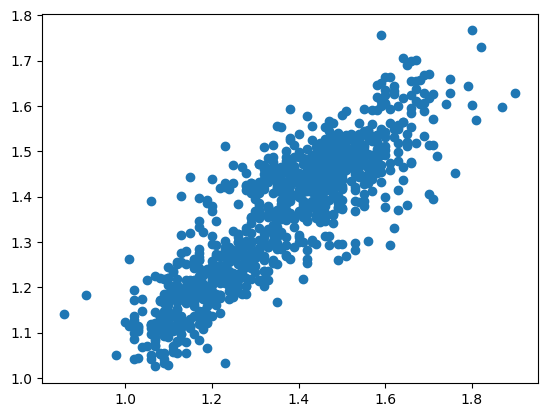

In [210]:
plt.scatter(y_test,lr.predict(X_test))
np.round(r2_score(y_test,lr.predict(X_test)),3)

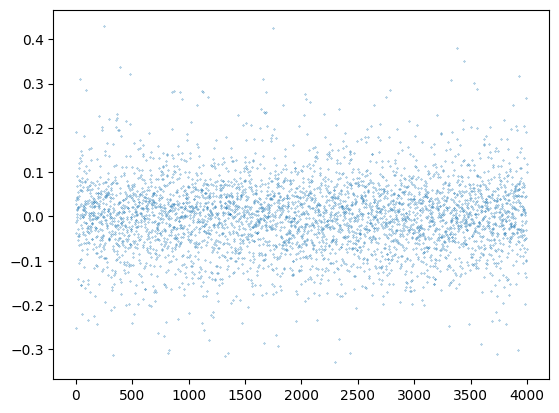

In [211]:
plt.scatter(range(4000),ypred-y_train,s=0.07)

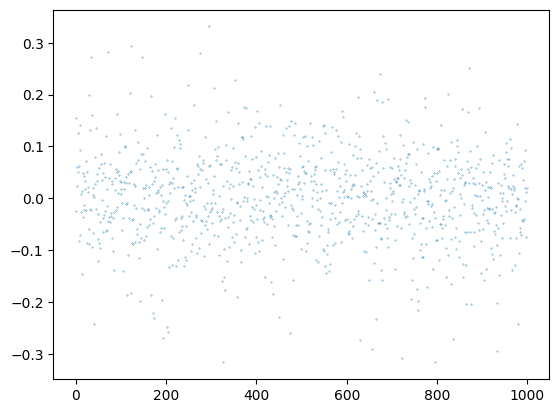

In [212]:
plt.scatter(range(1000),lr.predict(X_test)-y_test,s=0.07)

In [213]:
# This cell trains the entire dataset using Linear Regression.

features_std = StandardScaler().fit_transform(features)

lr = LinearRegression()
lr.fit(features_std,target)
ypred=lr.predict(features_std)
r2=np.round(r2_score(target,ypred),3)
pot_min=target.min()-0.05
pot_max=target.max()+0.05
fig=px.scatter(x=target,y=ypred,
           range_x=[pot_min,pot_max],
           range_y=[pot_min,pot_max],
              width=500, height=500)
fig.add_scatter(x=np.linspace(pot_min,pot_max,1000),
                y=np.linspace(pot_min,pot_max,1000),line_color='black',showlegend=False,line_dash='dash')
fig.update_xaxes(tickvals=np.linspace(0.8,2,7),title='Reduction potential from DFT (V)')
fig.update_yaxes(tickvals=np.linspace(0.8,2,7),title='Reduction potential from model (V)')
fig.update_layout(title='Linear Regression', title_x=0.5)
fig.add_annotation(
       
        text='R2 = '+str(r2),

        font=dict(
            size=12,
            color='red'
            ),
        showarrow=False,
         xref="paper", yref="paper",
        x=0.8, y=0.97
        
        )

fig.show()

In [214]:
fig = px.bar(list(features.columns), lr.coef_)
fig.show()

print(lr.coef_)

[ 0.05880088 -0.17975046  0.0047642  -0.01134845  0.04386859 -0.20008089
  0.08407377  0.08794043  0.03984475  0.04193793  0.14731594  0.246565
  0.21136606  0.09291895 -0.16552494 -0.02467194 -0.04231247  0.01664889
  0.02645516  0.06025113 -0.02351458 -0.01745786 -0.03023658 -0.05463899
 -0.06820477  0.02397922  0.0349585  -0.02600261 -0.01891095  0.01975056
  0.018476    0.0069297 ]


In [215]:
list(features.columns)

['MaxEStateIndex',
 'MolWt',
 'FpDensityMorgan1',
 'BCUT2D_LOGPLOW',
 'BalabanJ',
 'HallKierAlpha',
 'PEOE_VSA10',
 'PEOE_VSA11',
 'PEOE_VSA12',
 'PEOE_VSA2',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA8',
 'PEOE_VSA9',
 'SMR_VSA10',
 'SMR_VSA4',
 'SMR_VSA5',
 'SlogP_VSA3',
 'SlogP_VSA4',
 'SlogP_VSA6',
 'EState_VSA4',
 'EState_VSA6',
 'EState_VSA7',
 'EState_VSA8',
 'VSA_EState2',
 'VSA_EState9',
 'NHOHCount',
 'NumAliphaticHeterocycles',
 'fr_ArN',
 'fr_Ndealkylation1',
 'fr_bicyclic',
 'fr_unbrch_alkane']

In [216]:
# This cell executes a grid search to determine the best hyperparameters for LASSO regression.

lr = LinearRegression()
scores=cross_val_score(lr, features_std, target, cv=5) 
scores=cross_validate(lr, features_std, target, cv=5) 
scores=cross_val_predict(lr, features_std, target, cv=5) 



In [217]:
scores=cross_validate(lr,features_std,target,cv=5,return_train_score=True,scoring='r2')

In [218]:
scores

{'fit_time': array([0.00456786, 0.00776172, 0.011307  , 0.01283741, 0.01308584]),
 'score_time': array([0.00773931, 0.00149107, 0.00147486, 0.00192213, 0.00171232]),
 'test_score': array([0.75033106, 0.77190423, 0.77957569, 0.78049934, 0.75329436]),
 'train_score': array([0.77476764, 0.76924827, 0.76721935, 0.76678022, 0.7737571 ])}